## How to efficiently load images?

TODO: 
* Run the whole notebook in one go
* Insert logic that if loading_runtime.csv exist do not run experiments

In [1]:
import fastai
from fastai import *
from fastai.vision import *
import utils  # person functions

%matplotlib inline

In [2]:
# global variables
labels='train_stratified_split.csv'
padding_mode='border'
param_baseline = {'experiment': 'baseline', 
                  'image_size': 224, 
                  'batch_size': 32, 
                  'num_workers':0, 
                  'folder':'train'}

In [3]:
def load_train_image(data):
    'Just load the data and nothing else'
    for i, batch in enumerate(data.train_dl): 
        pass

def get_data(params):
    'wrapper function for parameter settings'
    return utils.get_data(size=param['image_size'], 
                          bs=param['batch_size'], 
                          csv=labels, 
                          folder=param['folder'], 
                          num_workers=param['num_workers'], 
                          padding_mode=padding_mode)

In [4]:
tfms = get_transforms(flip_vert=False, max_zoom=1);
[i.tfm.name for i in tfms[0]]  # transformation done on training data set

['TfmCrop', 'TfmPixel', 'TfmCoord', 'TfmAffine', 'TfmLighting', 'TfmLighting']

In [5]:
# first step is to resize the image
vision.transform._crop_pad??

Signature:
vision.transform._crop_pad(
    x,
    size,
    padding_mode='reflection',
    row_pct: <function uniform at 0x7fa1470a5048> = 0.5,
    col_pct: <function uniform at 0x7fa1470a5048> = 0.5,
) -> fastai.vision.image.Image
Docstring: <no docstring>
Source:   
def _crop_pad(x, size, padding_mode='reflection', row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    f_crop_pad = _crop_pad_image_points if isinstance(x, ImagePoints) else _crop_pad_default
    return f_crop_pad(x, size, padding_mode, row_pct, col_pct)
File:      ~/anaconda3/lib/python3.7/site-packages/fastai/vision/transform.py
Type:      function


In [6]:
if utils.data_fp.exists():
    exp_param = pd.read_csv(utils.data_fp/'loading_runtime.csv')
else:
    exp_param = pd.DataFrame(columns=['experiment', 'image_size', 'batch_size', 'num_workers', 'folder', 'avg', 'stdev'])

## Baseline: Loading unprocessed images
How long does it take to load images from a dataloader with all the transformation?

In [47]:
param = param_baseline.copy()

In [48]:
result = %timeit -n1 -r3 -o load_train_image(get_data(param))

6min 2s ± 764 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [49]:
param['avg'], param['stdev'] = result.average, result.stdev

In [50]:
exp_param = exp_param.append(param, ignore_index=True)

Each time I restart my computer, I rerun below code to warm the computer up and to see how much variance there are with the timing. 

In [51]:
param = param_baseline.copy()
param['experiment'] = 'baseline2'
result = %timeit -n1 -r3 -o load_train_image(get_data(param))
param['avg'], param['stdev'] = result.average, result.stdev
exp_param = exp_param.append(param, ignore_index=True)

6min 1s ± 544 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Experiment 1: Number of workers
How does the number of worker impact loading of the data?  
Are there a limit before overhead becomes not worth it?

In [56]:
workers_ls = [1,2,3,4,5,6,defaults.cpus,20]
param = param_baseline.copy()
param['experiment'] = 'number of workers'

In [57]:
for x in workers_ls:
    print(f'Workers: {x}')
    param['num_workers'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Workers: 1
6min 47s ± 138 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 2
3min 41s ± 135 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 3
2min 43s ± 185 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 4
2min 14s ± 592 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 5
1min 59s ± 432 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 6
1min 50s ± 347 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 12
1min 37s ± 272 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 20
1min 34s ± 475 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [92]:
compare = exp_param[exp_param.experiment.isin(['baseline', 'number of workers'])];
compare = compare.pivot('num_workers', 'experiment', ['avg', 'stdev'])/60; compare

avg                       stdev                  
experiment  baseline number of workers  baseline number of workers
num_workers                                                       
0            6.04523               NaN  0.012735               NaN
1                NaN          6.793643       NaN          0.002292
2                NaN          3.689164       NaN          0.002243
3                NaN          2.725418       NaN          0.003083
4                NaN          2.245350       NaN          0.009863
5                NaN          1.988428       NaN          0.007206
6                NaN          1.837741       NaN          0.005783
12               NaN          1.629123       NaN          0.004527
20               NaN          1.570049       NaN          0.007919

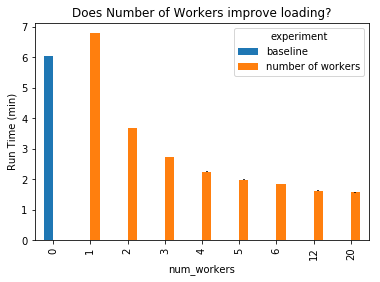

In [96]:
ax = compare.avg.plot(kind='bar', yerr=[compare.stdev.baseline, compare.stdev['number of workers']])
ax.set_title('Does Number of Workers improve loading?')
ax.set_ylabel('Run Time (min)');

In [97]:
# Rerun number of workers = 1 because to double check that the increase is true. 
param = param_baseline.copy()
param['num_workers'] = 1
%timeit -n1 -r3 load_train_image(get_data(param))

6min 52s ± 8.35 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


**Conclusion**: Yes, number of workers does improve loading. However, the improvement greatly decrease after value is 2. Interestingly setting number of workers to 1 takes longer. 

## Experiment 2: Batch Size

Batch size shouldn't impact the time because the amount of work is the same. But what if there is an interaction between num_workers and batch_size. Larger batchsize allow for better use of subprocess?

In [58]:
batch_ls = [1, 8, 16, 32, 64, 128]
param = param_baseline.copy()
param['experiment'] = 'batch_size'

num_worker = 0, the cpu usage is 50%. 

In [59]:
for x in batch_ls:
    print(f'Batch Size: {x}')
    param['batch_size'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Batch Size: 1
6min 6s ± 1.13 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 8
6min 2s ± 388 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 16
6min 1s ± 490 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 32
6min 1s ± 1.1 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 64
6min 3s ± 397 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Batch Size: 128
6min 5s ± 600 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [82]:
compare = exp_param[exp_param.experiment.isin(['baseline', 'batch_size'])];
compare = compare.pivot('batch_size', 'experiment', ['avg', 'stdev'])/60; compare

avg                stdev           
experiment baseline batch_size  baseline batch_size
batch_size                                         
1               NaN   6.100789       NaN   0.018886
8               NaN   6.033368       NaN   0.006461
16              NaN   6.027478       NaN   0.008172
32          6.04523   6.019953  0.012735   0.018371
64              NaN   6.054043       NaN   0.006612
128             NaN   6.092276       NaN   0.010000

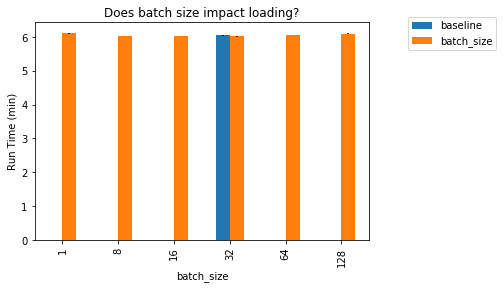

In [88]:
ax = compare.avg.plot(kind='bar', yerr=[compare.stdev.baseline, compare.stdev.batch_size])
ax.set_title('Does batch size impact loading?')
ax.set_ylabel('Run Time (min)')
ax.legend(bbox_to_anchor=(1.1, 1.05));

Conclusion: I do not think this was a good experiment because using just the main processor, pytorch probably doesn't have enough flexibility to improve load time to be noticable. 

## Experiment 3: Batch size plus number of workers
Since experiment 1 tested batch size of 32 and range of workers, this will just test with a larger batch size with the same range of workers. 

In [60]:
param = param_baseline.copy()
param['experiment'] = 'batch_size_plus_workers'
param['batch_size'] = 128   # it is unlikely my gpu will be able to fit larger batch than this

In [61]:
for x in workers_ls:
    print(f'Workers: {x}')
    param['num_workers'] = x
    result = %timeit -n1 -r3 -o load_train_image(get_data(param))
    param['avg'], param['stdev'] = result.average, result.stdev
    exp_param = exp_param.append(param, ignore_index=True)

Workers: 1
6min 29s ± 217 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 2
3min 26s ± 309 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 3
2min 31s ± 436 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 4
2min 4s ± 675 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 5
1min 50s ± 596 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 6
1min 40s ± 434 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 12
1min 29s ± 253 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Workers: 20
1min 29s ± 171 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [69]:
compare = exp_param[exp_param.experiment.isin(['number of workers', 'batch_size_plus_workers'])]
compare = compare.pivot('num_workers', 'batch_size', ['avg', 'stdev'])/60; compare

avg               stdev          
batch_size        32        128       32        128
num_workers                                        
1            6.793643  6.484117  0.002292  0.003625
2            3.689164  3.435584  0.002243  0.005154
3            2.725418  2.531536  0.003083  0.007262
4            2.245350  2.072690  0.009863  0.011250
5            1.988428  1.845093  0.007206  0.009926
6            1.837741  1.682247  0.005783  0.007230
12           1.629123  1.492126  0.004527  0.004223
20           1.570049  1.485930  0.007919  0.002847

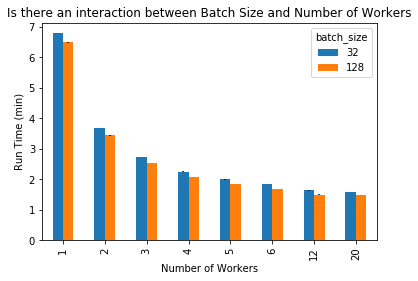

In [68]:
compare.avg.plot(kind='bar', yerr=[compare.stdev[32], compare.stdev[128]])
plt.title('Is there an interaction between Batch Size and Number of Workers')
plt.xlabel('Number of Workers')
plt.ylabel('Run Time (min)');

## Experiment 4: Preprocess image by resizing and saving the result

### Saving images as 224x224

In [7]:
dest = utils.data_fp/'train_224'
dest.mkdir(parents=True, exist_ok=True)
il = ImageImageList.from_folder(utils.data_train)  # get the list of images in train folder

In [35]:
def resize_tfms(fn, i):
    img = vision.open_image(fn)
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')
    img.save(dest/fn.name)

In [36]:
%%time 
fastai.callback.parallel(resize_tfms, il.items)  # num_workers = default.cpus which is 12

CPU times: user 12.8 s, sys: 1.75 s, total: 14.6 s
Wall time: 10min 26s


In [98]:
!du -sh ./data/train
!du -sh ./data/train_224

4.3G	./data/train
244M	./data/train_224


### Test loading

In [63]:
param = param_baseline.copy()
param['experiment'] = 'resized_image2'
param['folder'] = 'train_224'
param['num_workers'] = 4

In [64]:
result = %timeit -n1 -r3 -o load_train_image(get_data(param))

2min 15s ± 676 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [65]:
param['avg'], param['stdev'] = result.average, result.stdev
exp_param = exp_param.append(param, ignore_index=True)

In [71]:
compare = exp_param[(exp_param.batch_size == 32) & (exp_param.num_workers == 4)].sort_values('experiment');
compare

,experiment,image_size,batch_size,num_workers,folder,avg,stdev
6,number of workers,224,32,4,train,134.721007,0.591756
0,resized_image,224,32,4,train_224,136.922661,2.154793
25,resized_image2,224,32,4,train_224,135.136805,0.675696


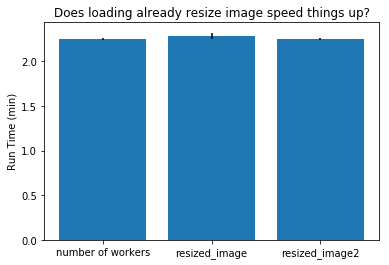

In [99]:
plt.bar(compare.experiment, compare.avg/60, yerr=compare.stdev/60)
plt.title('Does loading already resize image speed things up?')
plt.ylabel('Run Time (min)');

**Conclusion**: Saving resized image did not decrease the time it takes to load in the images. 

### Experiment 4b: just loading a image

In [68]:
%timeit -n3 -r3 img=vision.open_image(il.items[0])

12.4 ms ± 1.45 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## Experiment 5: Loading from disk vs ram?

I tried selecting for 8k of images. Loading that many images went beyond 16 gb of ram. 1k images takes around 6gb. 

In [8]:
images_fn = il.items[:1000]  # test on 1k images

### Loading from disk

In [9]:
%%timeit -n3 -r3 
for fn in images_fn:
    img = vision.open_image(fn)
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')

16.6 s ± 162 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Loading from ram

In [17]:
%timeit -n3 -r3 [vision.open_image(fn) for fn in images_fn]

9.11 s ± 90.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [15]:
images_ram = [vision.open_image(fn) for fn in images_fn]

In [16]:
%%timeit -n3 -r3
for img in images_ram:
    img = img.apply_tfms([vision.crop_pad()], size=224, resize_method=ResizeMethod.PAD, padding_mode='border')

7.5 s ± 7.78 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [18]:
del images_ram

**Conclusion**: It does look like loading the images into ram does help reduce the loading of images but the amount of space in ram required is signficantly higher than on disk. So it is unlikely to be able to use this trick unless you have a really small dataset. 

## Export result

In [8]:
exp_param

,experiment,image_size,batch_size,num_workers,folder,avg,stdev
0,resized_image,224,32,4,train_224,136.922661,2.154793
1,baseline,224,32,0,train,362.713806,0.764078
2,baseline2,224,32,0,train,361.873582,0.543994
3,number of workers,224,32,1,train,407.618560,0.137508
4,number of workers,224,32,2,train,221.349816,0.134594
5,number of workers,224,32,3,train,163.525060,0.185003
6,number of workers,224,32,4,train,134.721007,0.591756
7,number of workers,224,32,5,train,119.305661,0.432347
8,number of workers,224,32,6,train,110.264436,0.347007
9,number of workers,224,32,12,train,97.747387,0.271644


In [69]:
exp_param.to_csv(utils.data_fp/'loading_runtime.csv', index=False)

### Hardware of current system

In [70]:
hardware_info = !lshw -short -sanitize
for line in hardware_info:
    for word in ['WARNING','Description', '==', 'processor', 'memory', 'display']:
        if word in line: print(line)

H/W path              Device   Class       Description
/0/0                           memory      15GiB System memory
/0/1                           processor   AMD Ryzen 5 1600 Six-Core Processor
/0/100/1.3/0.2/4/0             display     GP106 [GeForce GTX 1060 6GB]
/0/100/3.1/0                   display     GP106 [GeForce GTX 1060 6GB]
